# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

 vbn,./# Imports

In [14]:
 import tensorflow as tf

In [15]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [17]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [19]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [20]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [21]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [22]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [23]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [24]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [34]:
import pathlib
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images')
        
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.JFIF")))
        

IMAGE_SIZE = (12,8)
TEST_IMAGE_PATHS

[WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/2583a08b-3169-46b7-887c-5fb9524dc7da.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/4eaa2b3d-a97c-40b1-8caf-09b4f51077fa.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/6f438fc1-3cbd-4ce2-a17e-69c48cdc632d.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/7608019d-9be4-4abb-b342-a8857b900add.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/76c93749-ae60-4e1b-812f-7326d0f7c201.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/8976d8bd-6d2c-4983-95f6-d5e5638c692f.jfif'),
 WindowsPath('C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images/899dd3c7-e17d-400b-a2d8-aef6a7de86c1.jfif'),
 WindowsPath('C:/Use

['chair', 'chair', 'chair', 'chair', 'chair', 'dining table', 'chair', 'chair', 'chair', 'chair', 'sink', 'chair', 'chair', 'chair', 'chair', 'sink', 'chair', 'chair', 'chair', 'vase', 'sink', 'chair', 'chair', 'chair', 'potted plant', 'microwave', 'sink', 'tv', 'sink', 'chair', 'chair', 'sink', 'chair', 'chair', 'dining table', 'chair', 'potted plant', 'potted plant', 'sink', 'bottle', 'chair', 'person', 'chair', 'potted plant', 'dining table', 'sink', 'chair', 'potted plant', 'chair', 'dining table', 'sink', 'dining table', 'dining table', 'chair', 'potted plant', 'potted plant', 'bottle', 'sink', 'chair', 'chair', 'vase', 'chair', 'sink', 'potted plant', 'dining table', 'chair', 'potted plant', 'dining table', 'sink', 'chair']
70
[[3, 6, 1, 2], [4, 7, 3, 6], [6, 7, 8, 10], [3, 6, 0, 1], [4, 6, 3, 4], [2, 6, 0, 3], [3, 6, 3, 5], [4, 7, 8, 10], [4, 7, 7, 9], [3, 6, 2, 4], [4, 6, 10, 11], [3, 6, 7, 9], [3, 6, 4, 6], [2, 7, 5, 7], [5, 7, 5, 7], [2, 2, 3, 5], [2, 5, 3, 4], [3, 6, 2, 3], 

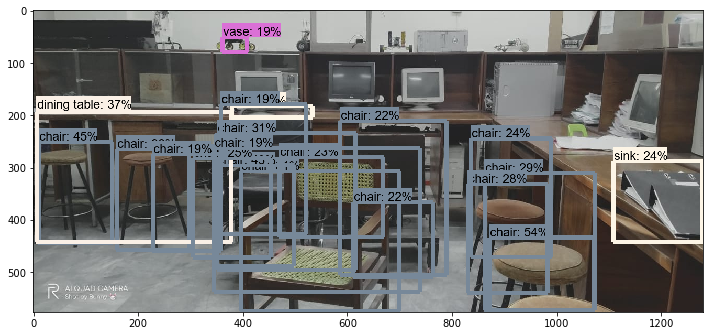

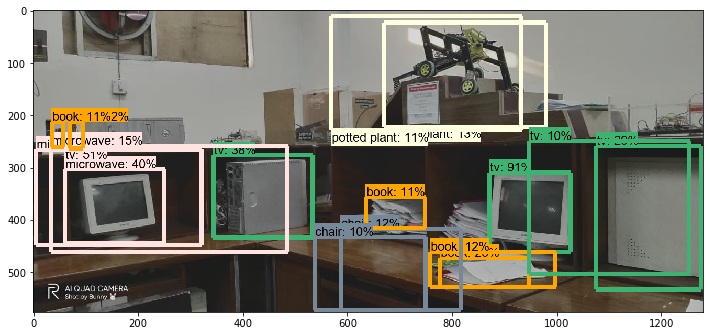

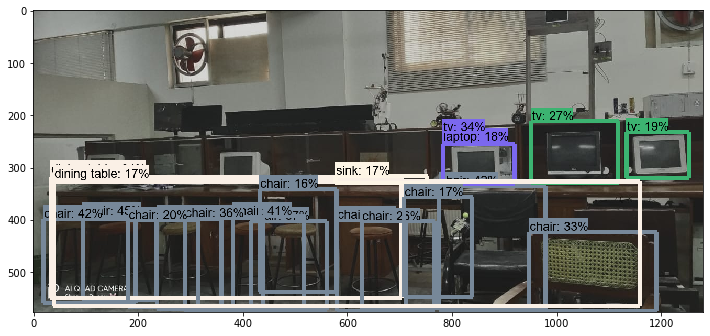

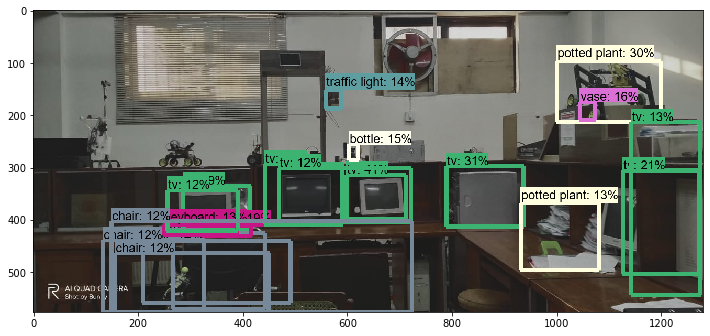

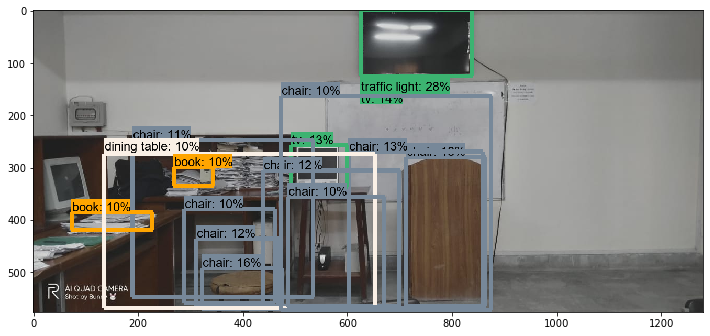

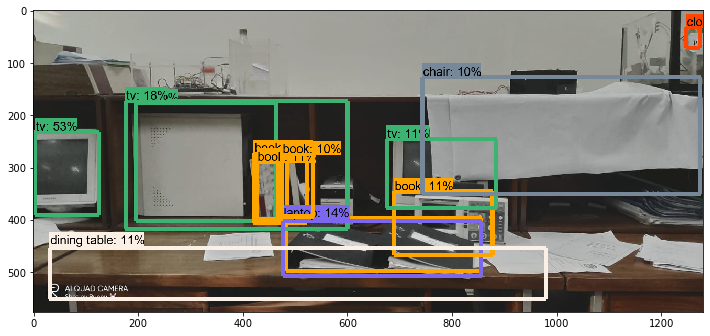

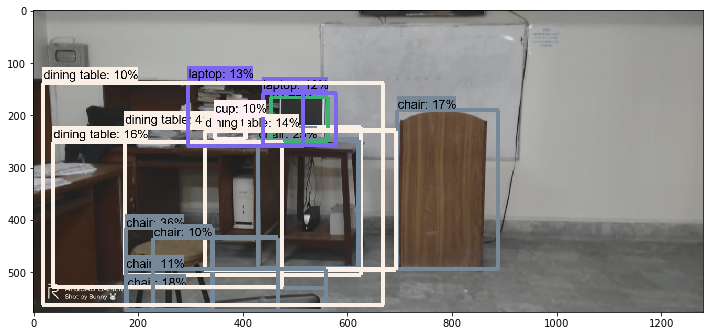

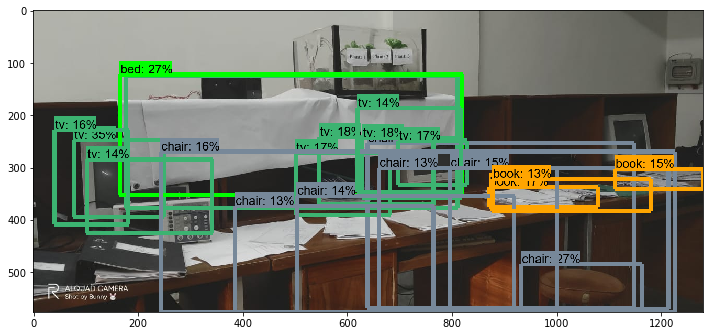

In [36]:
import cv2,time
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    sess.run(tf.global_variables_initializer())
    img = 1
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
      
      
    
    
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})

      out = vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8,
          min_score_thresh=0.1)
       
      
      #ymin = int((boxes[0][0][0]*image_height))
      #xmin = int((boxes[0][0][1]*image_width))
      #ymax = int((boxes[0][0][2]*image_height))
      #xmax = int((boxes[0][0][3]*image_width))
      #(left, right, top, bottom) = (xmin * image_width, xmax * image_width, ymin * image_height, ymax * image_height)
      #Result = np.array(image_np[ymin:ymax,xmin:xmax])
      #img_item = "C:/Users/Bunny/Documents/TensorFlow/models/research/object_detection/test_images"
      #cv2.imwrite(img_item, Result)
      
      #get objects name from image having score value greater then 50%)
      your_list = [category_index.get(value) for index,value in enumerate(classes[0]) if scores[0,index] > 0.1]
      name = [item['name'] for item in your_list] #names of objects in image
      print(name)              #rint out names i.e used in making decription
      print(len(name))         #lenght of objects , used while making description
      

      im_width, im_height = IMAGE_SIZE
      coordinates_list = []
      result = []  
      counter_for = 0
      for i,b in enumerate(boxes[0]):
          if scores[0,i] > 0.1:
             ymin = int((boxes[0][i][0]*im_height))  #top
             xmin = int((boxes[0][i][1]*im_width))   #left
             ymax = int((boxes[0][i][2]*im_height))  #bottom
             xmax = int((boxes[0][i][3]*im_width))    #right
             (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height) 
             coordinates_list.append([ymin, ymax, xmin, xmax])
             counter_for = counter_for + 1
             result.append([(xmin + xmax) / 2])
             #middle_col = (xmin + xmax) / 2
             #print(middle_row,middle_col)
             
                      
                    
      print(coordinates_list)
      print(result)   
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      
      
      

In [37]:
print(result)
print(name)
zipped = zip(result, name)
list(zipped)

  
          


[[4.0], [1.0], [4.0], [9.0], [7.5], [6.0], [6.0], [9.0], [6.5], [5.0], [6.5], [0.5], [9.0], [11.0], [6.0], [1.5], [6.0], [7.5], [5.0], [9.5], [4.5], [6.5], [9.5], [3.5], [0.5], [2.0], [2.5], [5.0], [6.5], [6.0], [6.0], [3.5], [8.5], [4.0], [8.5], [3.5]]
['tv', 'tv', 'bed', 'chair', 'chair', 'tv', 'tv', 'book', 'tv', 'tv', 'chair', 'tv', 'chair', 'book', 'chair', 'tv', 'tv', 'chair', 'chair', 'book', 'tv', 'tv', 'book', 'chair', 'tv', 'laptop', 'tv', 'tv', 'chair', 'bottle', 'dining table', 'chair', 'chair', 'tv', 'tv', 'tv']


[([4.0], 'tv'),
 ([1.0], 'tv'),
 ([4.0], 'bed'),
 ([9.0], 'chair'),
 ([7.5], 'chair'),
 ([6.0], 'tv'),
 ([6.0], 'tv'),
 ([9.0], 'book'),
 ([6.5], 'tv'),
 ([5.0], 'tv'),
 ([6.5], 'chair'),
 ([0.5], 'tv'),
 ([9.0], 'chair'),
 ([11.0], 'book'),
 ([6.0], 'chair'),
 ([1.5], 'tv'),
 ([6.0], 'tv'),
 ([7.5], 'chair'),
 ([5.0], 'chair'),
 ([9.5], 'book'),
 ([4.5], 'tv'),
 ([6.5], 'tv'),
 ([9.5], 'book'),
 ([3.5], 'chair'),
 ([0.5], 'tv'),
 ([2.0], 'laptop'),
 ([2.5], 'tv'),
 ([5.0], 'tv'),
 ([6.5], 'chair'),
 ([6.0], 'bottle'),
 ([6.0], 'dining table'),
 ([3.5], 'chair'),
 ([8.5], 'chair'),
 ([4.0], 'tv'),
 ([8.5], 'tv'),
 ([3.5], 'tv')]

In [38]:
for b,n in zip(result,name):
    if b >= [0.0] and  b <= [4.0]:
        print( "  the " + n + " is on left side of image") 
           
    elif b > [4.0]  and b <= [8.0]:
        print( "  the " + n + " is on center side of image")
           
    elif b > [8.0]  and b <= [12.0]: 
        print("  the " + n + " is on right side of image")  
           
    else:
        print(' ') 

  the tv is on left side of image
  the tv is on left side of image
  the bed is on left side of image
  the chair is on right side of image
  the chair is on center side of image
  the tv is on center side of image
  the tv is on center side of image
  the book is on right side of image
  the tv is on center side of image
  the tv is on center side of image
  the chair is on center side of image
  the tv is on left side of image
  the chair is on right side of image
  the book is on right side of image
  the chair is on center side of image
  the tv is on left side of image
  the tv is on center side of image
  the chair is on center side of image
  the chair is on center side of image
  the book is on right side of image
  the tv is on center side of image
  the tv is on center side of image
  the book is on right side of image
  the chair is on left side of image
  the tv is on left side of image
  the laptop is on left side of image
  the tv is on left side of image
  the tv is on 

In [40]:
print(name) 

def getDuplicatesWithCount(name):
    ''' Get frequency count of duplicate elements in the given list '''
    dictOfElems = dict()
    # Iterate over each element in list
    for elem in name:
        # If element exists in dict then increment its value else add it in dict
        if elem in dictOfElems:
            dictOfElems[elem] += 1
        else:
            dictOfElems[elem] = 1    
 
    # Filter key-value pairs in dictionary. Keep pairs whose value is greater than 1 i.e. only duplicate elements from list.
    dictOfElems = { key:value for key, value in dictOfElems.items() if value > 1}
    # Returns a dict of duplicate elements and thier frequency count
    return dictOfElems

# Get a dictionary containing duplicate elements in list and their frequency count
dictOfElems = getDuplicatesWithCount(name)     
 
for key, value in dictOfElems.items():
        print(key , ' :: ', value)

['tv', 'tv', 'bed', 'chair', 'chair', 'tv', 'tv', 'book', 'tv', 'tv', 'chair', 'tv', 'chair', 'book', 'chair', 'tv', 'tv', 'chair', 'chair', 'book', 'tv', 'tv', 'book', 'chair', 'tv', 'laptop', 'tv', 'tv', 'chair', 'bottle', 'dining table', 'chair', 'chair', 'tv', 'tv', 'tv']
tv  ::  17
chair  ::  11
book  ::  4
